In [126]:
import pandas as pd ### para manejo de datos
import a_funciones as funciones  ###archivo de funciones propias
import numpy as np #procesamiento eficiente de grandes conjuntos de datos y la realización de operaciones matemáticas
import plotly.express as px # Graficas lindas
from sklearn.model_selection import RandomizedSearchCV # búsqueda aleatoria de hiperparámetros 
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables 
import openpyxl # trabajar con archivos de Excel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.ensemble import RandomForestClassifier  # Clasificador bosques aleatoriost 
from sklearn.tree import DecisionTreeClassifier # Arboles de decision 
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler ## escalar variable
from sklearn.ensemble import GradientBoostingClassifier #Modelo de clasificacion
from sklearn.metrics import confusion_matrix #### Matriz de confusion 
import matplotlib.pyplot as plt #####Graficos
import seaborn as sns #####Graficos
from sklearn.metrics import accuracy_score #### medir precision del modelo 

In [127]:
###Cargar base desde github
df_ = pd.read_csv("https://raw.githubusercontent.com/andressj1/A-RH/main/Bases/df_fin.csv", sep=",")

## **Tratamiento de nulos**

In [128]:
####Convertimos VO a binaria 
df_['Attrition'] = df_['Attrition'].map({'No': 0, 'Yes': 1}).astype(int)

In [129]:
df_.info() ### no tiene faltantes pero crearemos unos para trabajar
df_.iloc[1,2] =np.nan  ### crear faltante en numérica
df_.iloc[1,10] =np.nan ### crear faltante en categórica
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EnvironmentSatisfaction  4284 non-null   int64 
 1   JobSatisfaction          4284 non-null   int64 
 2   WorkLifeBalance          4284 non-null   int64 
 3   Age                      4284 non-null   int64 
 4   BusinessTravel           4284 non-null   object
 5   Department               4284 non-null   object
 6   DistanceFromHome         4284 non-null   int64 
 7   Education                4284 non-null   int64 
 8   EducationField           4284 non-null   object
 9   Gender                   4284 non-null   object
 10  JobLevel                 4284 non-null   int64 
 11  JobRole                  4284 non-null   object
 12  MaritalStatus            4284 non-null   object
 13  MonthlyIncome            4284 non-null   int64 
 14  NumCompaniesWorked       4284 non-null  

In [130]:
dff=df_.dropna(axis=0) ### si se pone 1 se borra la columna con na si se pone 0, o se deja vacío, se borra la fila
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4283 entries, 0 to 4283
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EnvironmentSatisfaction  4283 non-null   int64  
 1   JobSatisfaction          4283 non-null   int64  
 2   WorkLifeBalance          4283 non-null   float64
 3   Age                      4283 non-null   int64  
 4   BusinessTravel           4283 non-null   object 
 5   Department               4283 non-null   object 
 6   DistanceFromHome         4283 non-null   int64  
 7   Education                4283 non-null   int64  
 8   EducationField           4283 non-null   object 
 9   Gender                   4283 non-null   object 
 10  JobLevel                 4283 non-null   float64
 11  JobRole                  4283 non-null   object 
 12  MaritalStatus            4283 non-null   object 
 13  MonthlyIncome            4283 non-null   int64  
 14  NumCompaniesWorked      

In [131]:
### generamos copia del df 
columnas = dff.columns
#list_cat = [col for col in columnas if df4[col].dtype == 'object']
#print(list_cat)
list_cat =['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

In [132]:
df3=funciones.imputar_f(df_,list_cat)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   BusinessTravel  4284 non-null   object
 1   Department      4284 non-null   object
 2   EducationField  4284 non-null   object
 3   Gender          4284 non-null   object
 4   JobRole         4284 non-null   object
 5   MaritalStatus   4284 non-null   object
dtypes: object(6)
memory usage: 200.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EnvironmentSatisfaction  4284 non-null   float64
 1   JobSatisfaction          4284 non-null   float64
 2   WorkLifeBalance          4284 non-null   float64
 3   Age                      4284 non-null   float64
 4   DistanceFromHome         4284 non-null   float64
 5   Education 

## **Obtener dummies**

In [133]:
#### dummies
list_dummies = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

In [134]:
####Conversion a categoricas a dummie
df = pd.get_dummies(df3, columns=list_dummies)

In [135]:
#####Separamos nuestra variable de las demas variables
y=df.Attrition
X1= df.loc[:,~df.columns.isin(['Attrition'])]


## **Seleccion de variables**

In [136]:
### 
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

In [137]:
######Seleccion de modelos
### 1. Regresion logistica 
m_rl = LogisticRegression()

### 2. Random forest
m_rf = RandomForestClassifier()

### 3 Arboles de decision
m_add = DecisionTreeClassifier()

### 4 GradientBoostingClassifieraa
m_gbc = GradientBoostingClassifier()


In [138]:
####Modelos
modelos = list([m_rl, m_rf, m_add, m_gbc])

In [139]:
#####Seleccion de variables 
var_names=funciones.sel_variables(modelos,X,y,threshold="2.8*mean")
var_names.shape


(6,)

In [140]:
X2=X[var_names] ### matriz con variables seleccionadas
X2.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4284 non-null   float64
 1   DistanceFromHome    4284 non-null   float64
 2   JobSatisfaction     4284 non-null   float64
 3   MonthlyIncome       4284 non-null   float64
 4   NumCompaniesWorked  4284 non-null   float64
 5   TotalWorkingYears   4284 non-null   float64
dtypes: float64(6)
memory usage: 200.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EnvironmentSatisfaction            4284 non-null   float64
 1   JobSatisfaction                    4284 non-null   float64
 2   WorkLifeBalance                    4284 non-null   float64
 3   Age                         

## **Modelo ganador**

In [141]:
## base con todas las variables
rmse_df = funciones.medir_modelos(modelos, "f1",X,y,10)
## base con variables seleccionadas
rmse_varsel = funciones.medir_modelos(modelos,"f1",X2,y,10)



In [142]:
rmse=pd.concat([rmse_df,rmse_varsel],axis=1)
rmse.columns=['rl', 'rf', 'add', 'm_gbc',
       'rl_Sel', 'rf_sel', 'add_sel', 'm_gbc_sel']

<Axes: >

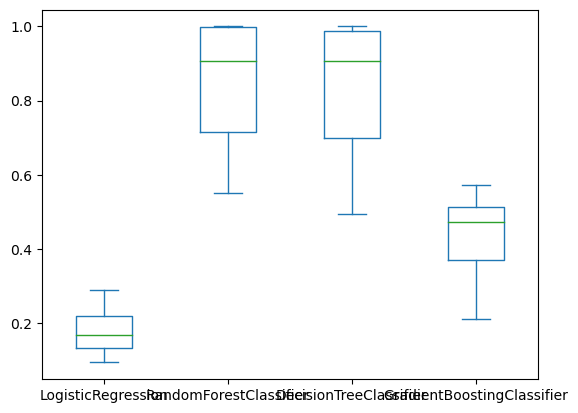

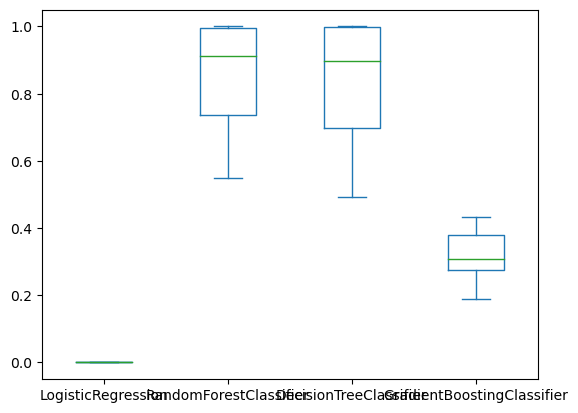

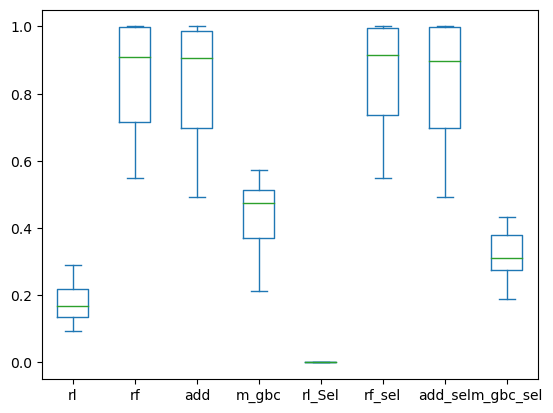

In [143]:
rmse_df.plot(kind='box') #### gráfico para modelos todas las varibles
rmse_varsel.plot(kind='box') ### gráfico para modelo variables seleccionadas
rmse.plot(kind='box') ### gráfico para modelos sel y todas las variables

rl           0.180266
rf           0.854590
add          0.827063
m_gbc        0.432159
rl_Sel       0.000000
rf_sel       0.857400
add_sel      0.826857
m_gbc_sel    0.319156
dtype: float64

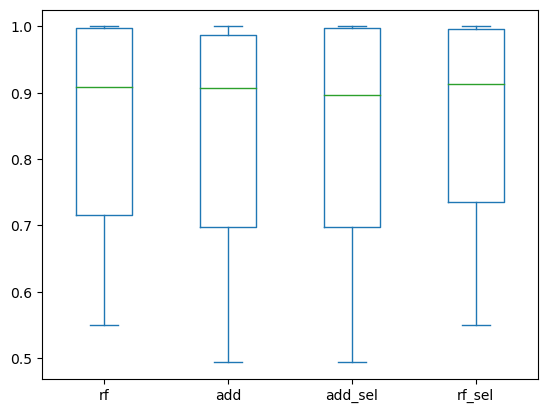

In [144]:
rmse2=rmse[['rf', 'add', 'add_sel', 'rf_sel']]
rmse2.plot(kind='box') ### gráfico para modelos sel y todas las variables
rmse.mean() ### medias de mape

## **Afinamiento de hiperparámetros**

**Random forest con selección de variables, antes de ajustes de hiperparámetros**

In [145]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42, stratify = y)

# Entrenar el modelo de Random Forest
m_rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de datos de prueba
y_pred = m_rf.predict(X_test)

In [146]:
# Crear y ajustar el modelo Random Forest
rf_sfs = RandomForestClassifier()
rf_sfs.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred1 = rf_sfs.predict(X_test)

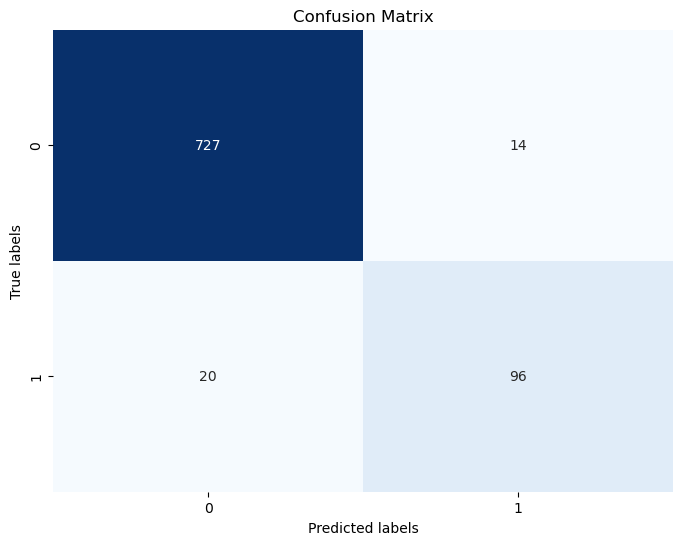

<Figure size 640x480 with 0 Axes>

In [157]:
conf_matrix = confusion_matrix(y_test, y_pred1)

# Crear un mapa de calor con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Descargar imagen 
plt.savefig('Matrizs\\confusion_matrix_antes_del_ajuste_de_hip.png')

In [148]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred1)
print(f'Precisión del modelo: {accuracy}')


Precisión del modelo: 0.9603267211201867


**Random forest con selección de variables, con ajustes de hiperparámetros**

In [149]:
#############Hiperparameter tunning
param_grid = [{'n_estimators': [3, 500, 100], 'max_features': [5,20],
               'min_samples_split': [100, 20, 5]}]


In [150]:
###Ajuste del modelo 
tun_rf=RandomizedSearchCV(m_rf,param_distributions=param_grid,n_iter=10,scoring="f1")
tun_rf.fit(X_train,y_train)

# Hacer predicciones en el conjunto de prueba
y_pred3 = tun_rf.predict(X_test)

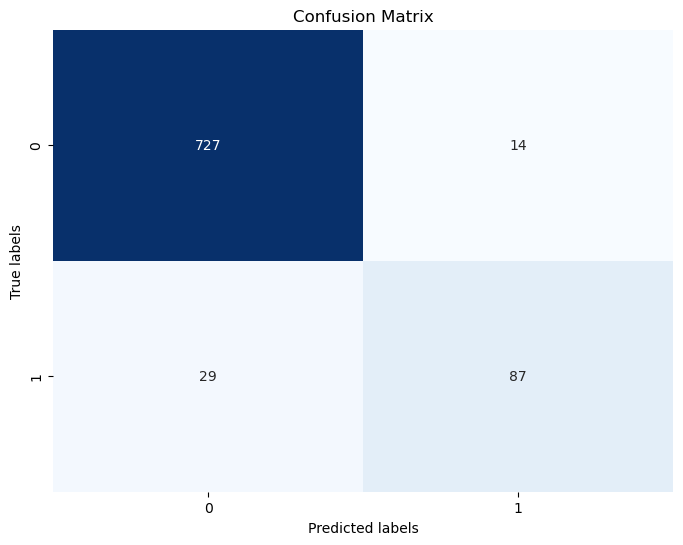

<Figure size 640x480 with 0 Axes>

In [158]:
conf_matrix = confusion_matrix(y_test, y_pred3)

# Crear un mapa de calor con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Descargar imagen 
plt.savefig('Matrizs\\confusion_matrix_con_ajuste_de_hip.png')

In [152]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred3)
print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.9498249708284714


## **Exportación del modelo**

In [153]:
### Guardar el modelo
rf_final = tun_rf.best_estimator_ 

In [154]:
### función para exportar y guardar objetos de python (cualqueira)

joblib.dump(rf_final, "salidas\\rf_final.pkl") ## modelo con afinamiento
joblib.dump(list_cat, "salidas\\list_cat.pkl") ### para realizar imputacion
joblib.dump(list_dummies, "salidas\\list_dummies.pkl")  ### para convertir a dummies
joblib.dump(var_names, "salidas\\var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "salidas\\scaler.pkl") ## 

['salidas\\scaler.pkl']